# Examining Influential Factors on Poverty Status
## Clustering
---

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer

from kmodes.kmodes import KModes
from kmodes.kprototypes import KPrototypes

pd.set_option('display.max_columns', None)

#KMeans warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
#import data set
df = pd.read_csv("https://media.githubusercontent.com/media/Rpierre98/DSI-320-Group-Project/main/data/clean_data/cleaned_data.csv")

### Preprocessing

In [6]:
#find list of numerical columns
numeric_columns = df.select_dtypes(include=np.number).columns.tolist()
numeric_columns

['AGE',
 'OUT_POCKET_NONPREM',
 'OUT_POCKET_OC',
 'WEEKS_WRK',
 'GROSS_PAY',
 'EARN_TOTAL',
 'TOTAL_DIS_INC',
 'TIME_ASSIST',
 'CHLD_SUP',
 'ADJ_GROSS_INC']

In [8]:
#find list of categorical columns
categorical_columns = df.select_dtypes(include='object').columns.tolist()
categorical_columns

['STATE',
 'FAM_RELATIONSHIP',
 'OCCUPATION',
 'EDU_LVL',
 'MARITAL',
 'SEX',
 'HOUSEHOLD_SUMMARY',
 'MILITARY',
 'CERT_REQ',
 'TROUB_BATHE',
 'TROUB_HEAR',
 'TROUB_SEE',
 'TROUB_ALONE',
 'TROUB_WALK',
 'TROUB_CONC',
 'HISPANIC',
 'IMMIGR_YR',
 'CITIZENSHIP',
 'DISABLED',
 'RACE',
 'WORK_INDUSTRY',
 'LABOR_STATUS',
 'WRK_STATUS',
 'WRK_CLASS_LONGEST',
 'LONGEST_IND',
 'NO_WRK_RSN',
 'FT_PT',
 'EARN_SOURCE',
 'ERN_OTR',
 'WORK_DIS',
 'DIS_INC',
 'OTH_DIS_INC',
 'FIN_ASSIST',
 'OTH_INC',
 'CASH_ASSIST',
 'WIC',
 'TAX_FILE_STAT',
 'HEALTH_INS',
 'PUB_INS',
 'PRIV_INS',
 'POV_STS',
 'POV_LVL']

In [9]:
#only clustering people in poverty
df = df.loc[df["POV_STS"] == 'in poverty']

In [11]:
#select features for clustering
X = df[['FAM_RELATIONSHIP', 'OCCUPATION', 'EDU_LVL', 'MARITAL', 'SEX','MILITARY', 'HISPANIC', 'IMMIGR_YR',
        'CITIZENSHIP', 'DISABLED','RACE', 'WORK_INDUSTRY', 'LABOR_STATUS', 'WRK_STATUS', 'NO_WRK_RSN',
        'FT_PT', 'EARN_SOURCE', 'ERN_OTR', 'WORK_DIS', 'TAX_FILE_STAT','HEALTH_INS', 'PUB_INS', 'PRIV_INS',
         'WEEKS_WRK', 'AGE', 'EARN_TOTAL', 'ADJ_GROSS_INC','OUT_POCKET_NONPREM', 'OUT_POCKET_OC', 'POV_STS']]

In [12]:
#scale appropriate numeric features
ctx = ColumnTransformer([
    ('ss', StandardScaler(), ['WEEKS_WRK', 'AGE', 'EARN_TOTAL', 'ADJ_GROSS_INC',
                              'OUT_POCKET_NONPREM', 'OUT_POCKET_OC'])],
    verbose_feature_names_out = False, remainder='passthrough')

In [13]:
#transform data and place into dataframe
X_transformed = ctx.fit_transform(X)
X_transformed = pd.DataFrame(X_transformed,columns = ctx.get_feature_names_out())

In [16]:
#convert appropriate columns back to float type
X_transformed = X_transformed.astype({'WEEKS_WRK':'float','AGE':'float',
                                     'EARN_TOTAL':'float','ADJ_GROSS_INC':'float',
                                     'OUT_POCKET_NONPREM':'float','OUT_POCKET_OC':'float'})

In [19]:
#create numerical and categorical matrices for clustering
X_num = X_transformed[['WEEKS_WRK', 'AGE', 'EARN_TOTAL', 'ADJ_GROSS_INC','OUT_POCKET_NONPREM', 'OUT_POCKET_OC']]
X_cat = X_transformed.drop(columns = ['WEEKS_WRK', 'AGE', 'EARN_TOTAL', 'ADJ_GROSS_INC','OUT_POCKET_NONPREM',
                                      'OUT_POCKET_OC'])

### Helper Functions

In [40]:
#Plot heatmap presenting correlation of numeric variables given a cluster
def cluster_heatmap(df, cluster):
    plt.figure(figsize=(8, 8))
    plt.title(f'Correlation of Features - Cluster {cluster}', size=20)
    corr = round(df.loc[df['cluster'] == cluster].corr(),2)
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, annot = True, cmap = 'bone',mask = mask, square = True,vmin=-1,vmax=1)
    plt.tight_layout()
    plt.savefig(f"../images/clustering/correlation_heatmap_kmeans_cluster_{cluster}");

In [126]:
#graphically represent percentage of people per cluster
def cluster_plot(df, col, algorithm):
    cluster_group = df[col].value_counts(normalize=True)
    cluster_group.plot.bar(figsize = (8,8), colormap = 'cividis')
    plt.ylabel("Frequency", fontsize = 12)
    plt.xlabel("Cluster", fontsize = 12)
    plt.xticks(rotation=360)
    plt.title(f"{algorithm} - Clusters", fontweight = 'bold')
    plt.tight_layout()
    plt.savefig(f'../images/clustering/{algorithm}_cluster.png');

## Numerical Clustering
---

### KMeans

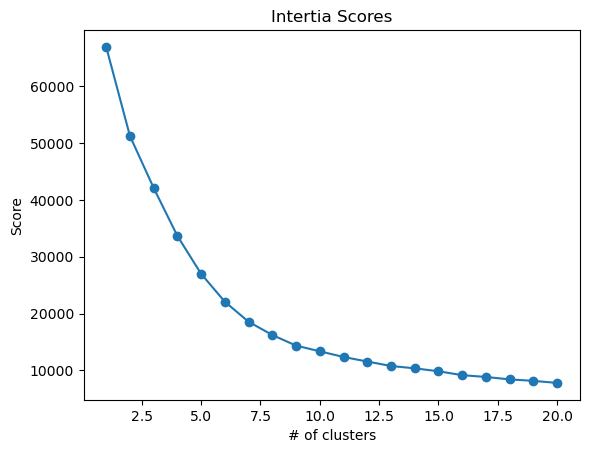

In [22]:
#check inertia scores to find optimal number of clusters
inertia_list = []

for k in range(1,21):
    kmeans = KMeans(n_clusters=k, random_state = 42)
    kmeans.fit(X_num)
    inertia_list.append(kmeans.inertia_)

plt.plot(range(1,21), inertia_list, marker = 'o')
plt.xlabel("# of clusters")
plt.ylabel("Score")
plt.title("Intertia Scores");

Soft elbow appears to be between 5 and 10.

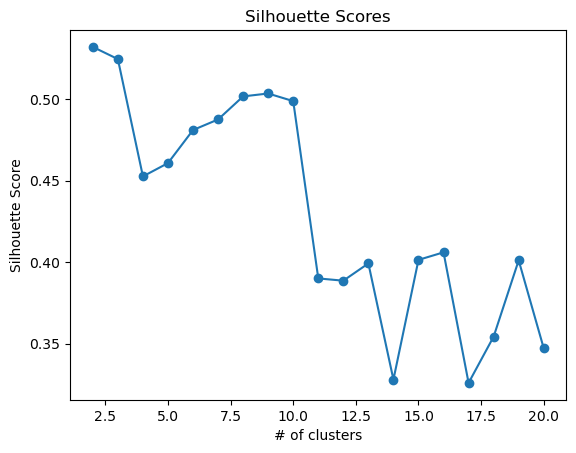

In [23]:
#check silhouette scores to find optimal number of clusters
silhouette_list = []

for k in range(2,21):
    kmeans = KMeans(n_clusters=k,random_state = 42)
    kmeans.fit(X_num)
    silhouette_list.append(silhouette_score(X_num, kmeans.labels_))
    
plt.plot(range(2, 21), silhouette_list, marker = 'o')
plt.xlabel('# of clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Scores');

In [24]:
silhouette_list

[0.5322277427599589,
 0.5247509027995888,
 0.45267564941592653,
 0.4608558194426233,
 0.4811719321350967,
 0.4876652672288141,
 0.5018341108751407,
 0.5036166424218214,
 0.49892641712455565,
 0.39000393298140484,
 0.3886149231600559,
 0.39922533789904474,
 0.3278516742177532,
 0.40140517281278,
 0.40603292788859924,
 0.3258077346846517,
 0.35424667976594937,
 0.4011209381525167,
 0.3470904713829208]

Silhouette score suggests 8 or 9 clusters. 2 or 3 clusters have slightly higher silhouette scores but few clusters may not be enough to properly separate the data.

In [25]:
#Fit data to 9 clusters with KMeans
kmeans = KMeans(n_clusters=9,random_state = 42)
kmeans.fit(X_num)
X_kmeans = X[X_num.columns].copy()
X_kmeans['cluster'] = kmeans.labels_

### KMeans Analysis

In [27]:
#frequency of observations in each cluster
X_kmeans['cluster'].value_counts(normalize=True)

1    0.407786
2    0.377467
6    0.127287
0    0.046376
5    0.033818
3    0.002691
8    0.002243
7    0.001973
4    0.000359
Name: cluster, dtype: float64

In [28]:
#amount of observations in each cluster
X_kmeans['cluster'].value_counts().to_frame('count')

,count
1,4546
2,4208
6,1419
0,517
5,377
3,30
8,25
7,22
4,4


Majority of data is located in Cluster 1 and Cluster 2.

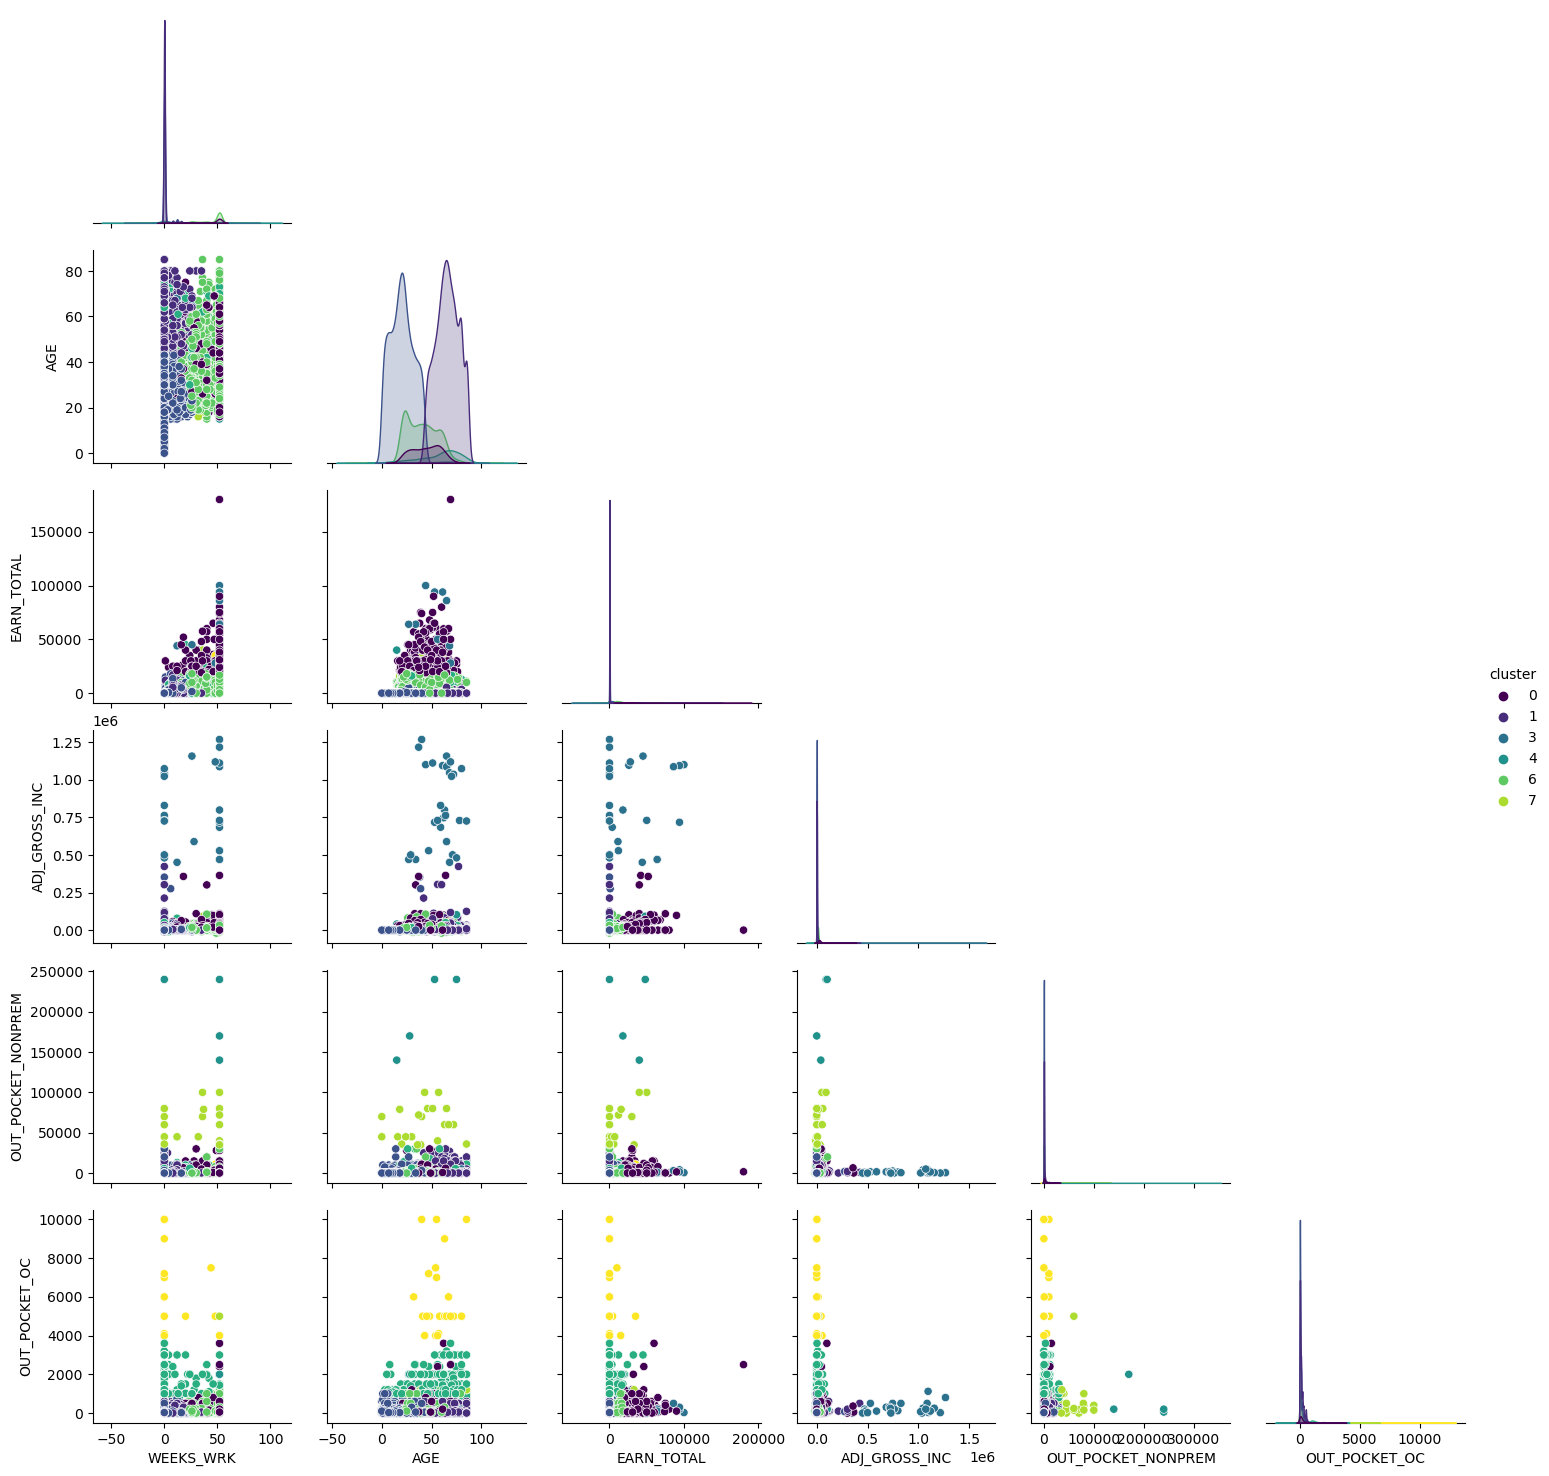

In [29]:
sns.pairplot(data = X_kmeans, hue = 'cluster', corner = True, palette = 'viridis')
plt.savefig("../images/clustering/kmeans_pairplot");

Comparison of Cluster Distributions across selected numerical features.

In [134]:
#averages of features by cluster
X_kmeans.groupby("cluster").agg(['mean', 'median', 'std'])

WEEKS_WRK                          AGE                    \
              mean median        std       mean median        std   
cluster                                                             
0        48.088975   52.0   8.995467  44.313346   45.0  14.014890   
1         0.589309    0.0   3.048643  65.525077   65.0  11.399744   
2         1.197006    0.0   4.037019  20.235979   20.0  11.574406   
3        28.066667   38.0  25.004735  59.433333   63.5  14.979718   
4        39.000000   52.0  26.000000  42.750000   40.5  26.663021   
5         5.193634    0.0  13.395663  58.437666   63.0  19.578727   
6        45.518675   52.0  10.101399  40.348837   39.0  15.132893   
7        25.863636   34.0  23.948945  41.090909   39.5  22.530211   
8         6.560000    0.0  16.160858  58.640000   57.0  13.545848   

           EARN_TOTAL                         ADJ_GROSS_INC            \
                 mean   median           std           mean    median   
cluster                                                                 
0        29099.123791  25000.0  12781.214516   26394.990329   24000.0   
1          139.566652      0.0    942.226581    2014.694677       0.0   
2          379.588165      0.0   1488.184227     912.375475       0.0   
3        24666.866667   1825.0  34006.922166  837975.666667  780622.5   
4        26500.000000  29000.0  21748.563171   58580.750000   66000.5   
5         1311.392573      0.0   4560.851074    3998.111406       0.0   
6         7497.477801   8000.0   5710.584783    9513.753347    9294.0   
7         8913.727273      0.0  15147.670351   15077.045455    1648.5   
8         2568.000000      0.0   7645.190209    5721.480000       0.0   

                       OUT_POCKET_NONPREM                          \
                   std               mean    median           std   
cluster                                                             
0         30238.779609        1780.808511     300.0   3618.668654   
1         11505.014493         671.416410      30.0   2074.096026   
2          7537.606202         271.985029       0.0   1243.601869   
3        265450.110529        1069.600000     500.0   1359.069017   
4         47634.212504      197500.000000  205000.0  50579.969685   
5          9698.594208        2643.132626    1200.0   4210.701140   
6          8968.399472         560.981677       0.0   1703.023218   
7         26008.061914       59454.545455   60000.0  21185.635908   
8         13319.528280        2923.160000     250.0   4321.778527   

        OUT_POCKET_OC                       
                 mean  median          std  
cluster                                     
0          200.303675   100.0   338.042167  
1          110.890673    50.0   145.384094  
2           66.799192    20.0   121.067959  
3          229.900000   160.0   256.635304  
4          612.500000   200.0   927.698766  
5         1380.843501  1200.0   570.741809  
6          124.915433    50.0   199.028210  
7          649.772727   400.0  1049.220206  
8         5952.000000  5000.0  1928.323970

In [32]:
#min/max of features by cluster
X_kmeans.groupby("cluster").agg(['min', 'max'])

WEEKS_WRK     AGE     EARN_TOTAL         ADJ_GROSS_INC           \
              min max min max        min     max           min      max   
cluster                                                                   
0               1  52  16  76      17000  180000             0   363805   
1               0  35  42  85          0   18000         -9999   423137   
2               0  28   0  44          0   18000         -9999   352215   
3               0  52  27  85          0  100000        450775  1267706   
4               0  52  15  75          0   48000             0   102322   
5               0  52   3  85          0   45000         -9999    78934   
6              14  52  15  85          0   19000        -19935   106032   
7               0  52   0  85          0   50002         -9978    91425   
8               0  52  32  85          0   35000             0    52321   

        OUT_POCKET_NONPREM         OUT_POCKET_OC         
                       min     max           min    max  
cluster                                                  
0                        0   30000             0   3600  
1                        0   30000             0    800  
2                        0   30000             0   1000  
3                        0    5000             0   1122  
4                   140000  240000            50   2000  
5                        0   30000           700   3600  
6                        0   30000             0   1200  
7                    35000  100000             0   5000  
8                        0   11000          4000  10000

* Clusters are split on age, income, and health expenses.
* Clusters 1,2,5 and 8 have a median of 0 weeks worked per year and understandably $0 of ERN_TOTAL and ADJ_GROSS_INC. 
* Individuals in Cluster 4 and 7 easily spend the most for out of pocket non premium medical care whereas individuals in Cluster 8 spend the most on average for out of pocket over the counter care.
* Interestingly, on average, (median) individuals in Cluster 1,5,7, and 8 spend more on out of pocket non premium medical care than they make (EARN_TOTAL & ADJ_GROSS_INC). 
* Cluster 2 appears to contain many young people based on max and median age. On the other hand, Cluster 1 is composed of mainly older individuals (42 - 85). 
* Wealthiest cluster on average is hard to assess due to due Cluster 3 and Cluster 4 containing only 34 people combined. 
* Cluster 3 has an abnormally high average ADJ_GROSS_INC value and Cluster 4 has an abnormally high OUT_POCKET_NONPREM value. It seems that outlier data points will be placed into groupings with few members.
* Many clusters with few members exhibit high standard deviation signifying a lack of cohesion within the group.

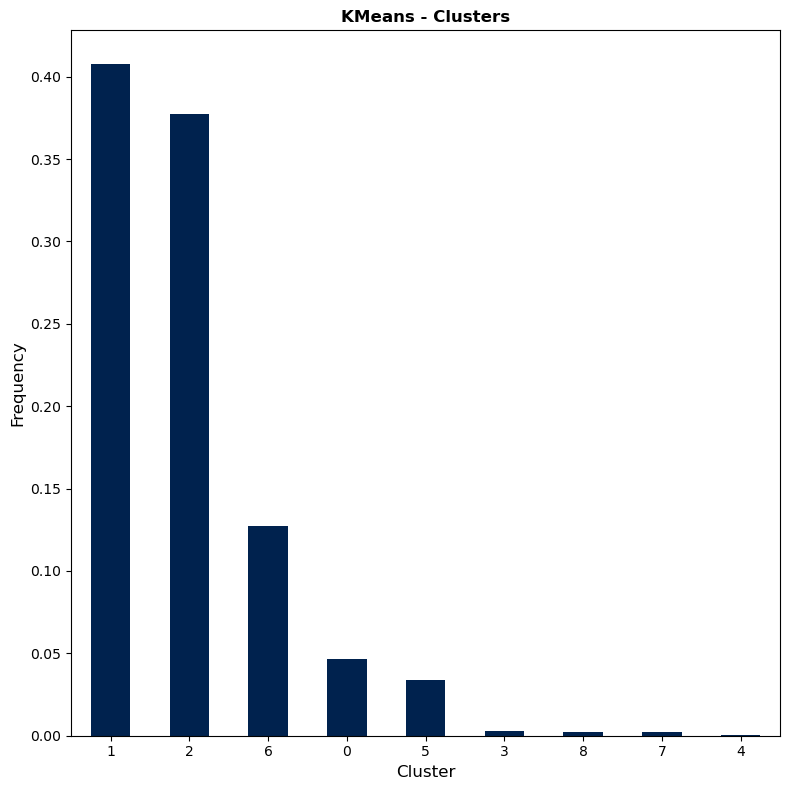

In [129]:
#graphically represent percentage of people per cluster
cluster_plot(X_kmeans, 'cluster', 'KMeans')

Together, Cluster 1 and Cluster 2 contain 8,754 (78%) people in poverty from the dataset. Major difference between these clusters is age. These two clusters are good candidates for further analysis.

### Cluster Comparison

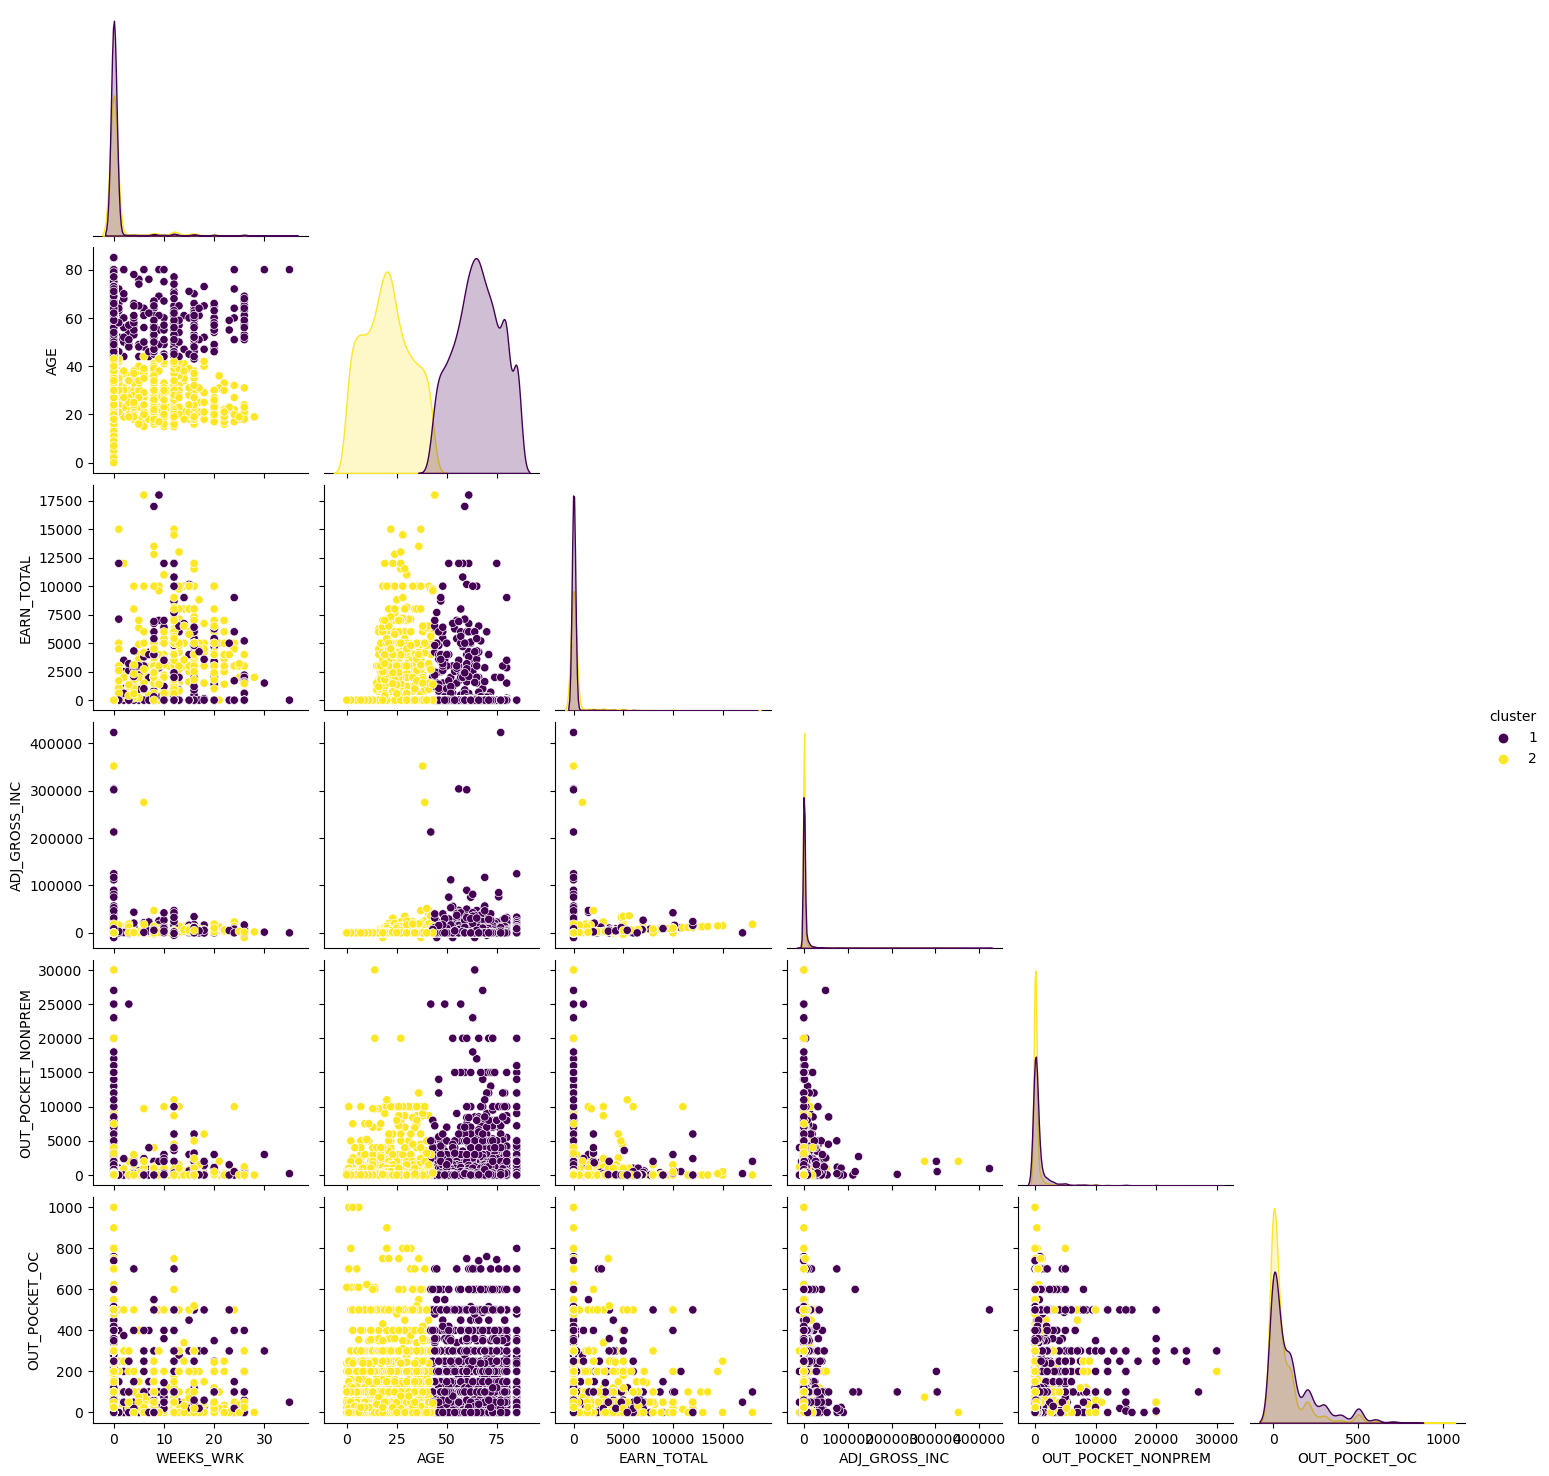

In [151]:
#check distribution comparison of individuals in poverty in Cluster 1 and Cluster 2
sns.pairplot(data = X_kmeans.loc[X_kmeans['cluster'].isin([1,2])],
             hue = 'cluster', corner = True, palette = 'viridis')
plt.savefig("../images/clustering/kmeans_pairplot_1_2.png");

Comparison of numerical feature distributions for Cluster 1 & Cluster 2. 

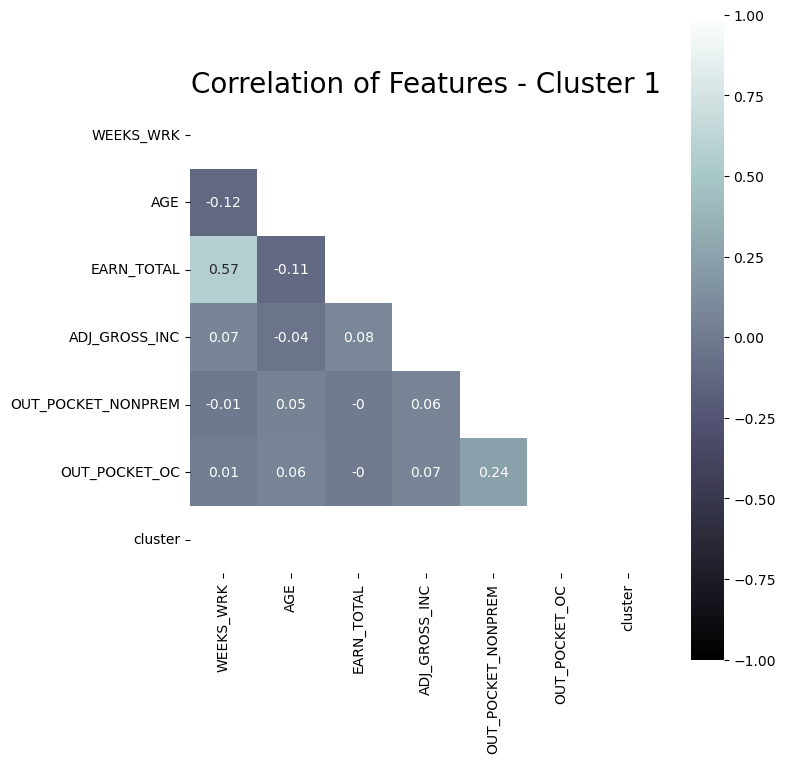

In [42]:
#create correlation heatmap for Cluster 1
cluster_heatmap(X_kmeans,1)

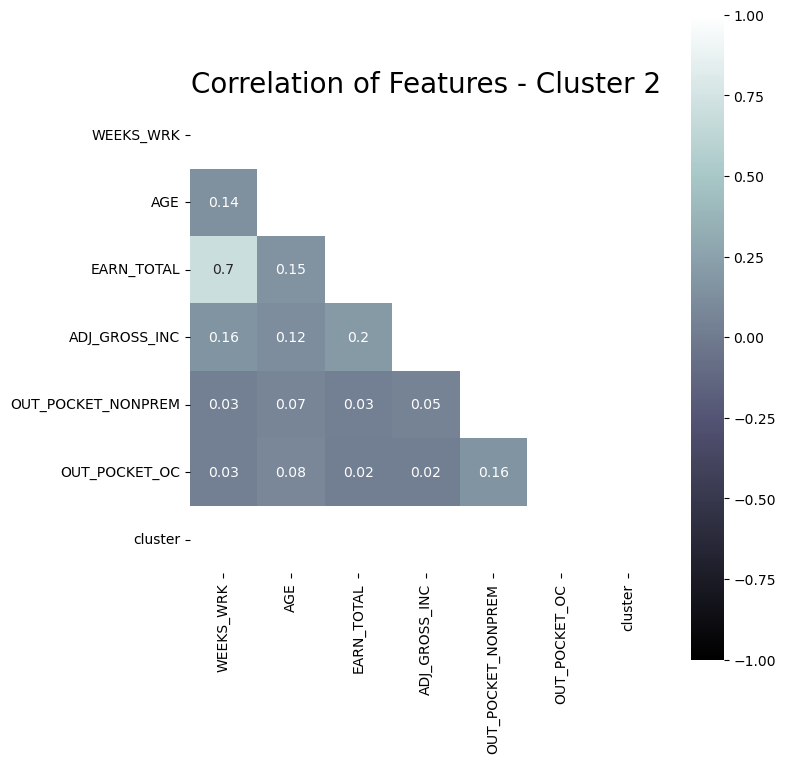

In [43]:
#create correlation heatmap for Cluster 2
cluster_heatmap(X_kmeans,2)

* As evidenced above, the greatest difference between these two clusters is age. 
* Distribution shapes of OUT_POCKET_OC, OUT_POCKET_NONPREM, EARN_TOTAL, and WEEKS_WRK, and ADJ_GROSS_INC between the clusters are very similar. Cluster 2 (younger cluster on average) has greater  a number of people with $0 value in OUT_POCKET_OC, OUT_POCKET_NONPREM, and ADJ_GROSS_INC.
* Considering correlation, the most notable differences is:
> There is a slightly negative correlation between AGE and WEEKS_WRK (and EARN_TOTAL/ADJ_GROSS_INCOME by extension) in Cluster 1. <br>
> On the other hand, there is a slightly positive correlation between AGE and these same features in Cluster 2. <br>
> As old people become older, they may work and earn less. Younger individuals generally don't face the same phyiscal phenomenon. They can continually work more hours and earn more work as they become more experienced in their craft.

### DBScan

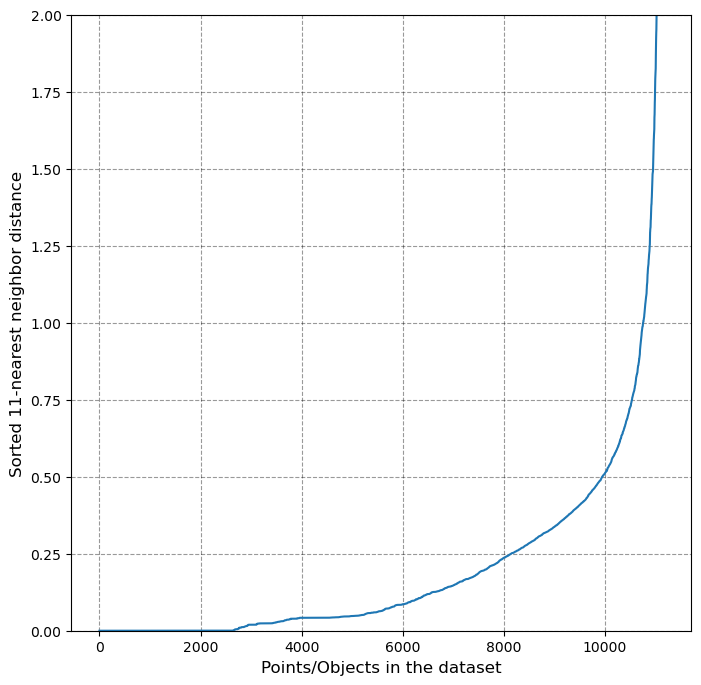

In [59]:
#tips for hyperparemeter tuning of DBScan
#https://stackoverflow.com/questions/15050389/estimating-choosing-optimal-hyperparameters-for-dbscan

#find optimal epsilon
def get_kdist_plot(X, k, radius_nbrs=1.0):

    nbrs = NearestNeighbors(n_neighbors=k, radius=radius_nbrs).fit(X)

    # For each point, compute distances to its k-nearest neighbors
    distances, indices = nbrs.kneighbors(X) 
                                       
    distances = np.sort(distances, axis=0)
    distances = distances[:, k-1]

    # Plot the sorted K-nearest neighbor distance for each point in the dataset
    plt.figure(figsize=(8,8))
    plt.plot(distances)
    plt.xlabel('Points/Objects in the dataset', fontsize=12)
    plt.ylabel('Sorted {}-nearest neighbor distance'.format(k), fontsize=12)
    plt.grid(True, linestyle="--", color='black', alpha=0.4)
    plt.ylim(bottom = 0, top = 2)
    plt.savefig("../images/clustering/kdist_plot.png")
    plt.show()


k = 2 * X_num.shape[-1] - 1 
get_kdist_plot(X_num, k)

Optimal epsilon may be between .1 and 1 (greatest curvature)

In [55]:
#search for optimal epsilon and min_samples with silhouette score

eps_list = [.25,.5,.7,.75]
sample_list = [9,11,13,15,17]

silhouette_list_db = []

for value in eps_list:
    db_dict_silhouette = {}
    for other_value in sample_list:
        db = DBSCAN(eps=value, min_samples=other_value,n_jobs=-1)
        db.fit(X_num)
        db_dict_silhouette[(value,other_value)] = silhouette_score(X_num,db.labels_)
    silhouette_list_db.append(db_dict_silhouette)

In [56]:
silhouette_list_db

[{(0.25, 9): -0.26354223812684685,
  (0.25, 11): -0.13981507084009046,
  (0.25, 13): -0.1299718394232761,
  (0.25, 15): 0.21161709151314892,
  (0.25, 17): 0.07950305781282445},
 {(0.5, 9): 0.40603538614937024,
  (0.5, 11): 0.4406877957967711,
  (0.5, 13): 0.44388294068446865,
  (0.5, 15): 0.5161988026480748,
  (0.5, 17): 0.14453848719665485},
 {(0.7, 9): 0.3844388552752723,
  (0.7, 11): 0.6495230297855942,
  (0.7, 13): 0.5448157076938736,
  (0.7, 15): 0.4224216057735029,
  (0.7, 17): 0.5430938387074358},
 {(0.75, 9): 0.6653628105496174,
  (0.75, 11): 0.6594202117724798,
  (0.75, 13): 0.6564676402563453,
  (0.75, 15): 0.5449954239247617,
  (0.75, 17): 0.5444332424869422}]

Epsilon of .75 and 9 minimum samples seems to be optimal.

In [61]:
#Fit data with DBScan
db = DBSCAN(eps=.75, min_samples=9)
db.fit(X_num)
X_db = X[X_num.columns].copy()
X_db['cluster'] = db.labels_

### DBScan Analysis

In [62]:
X_db['cluster'].value_counts(normalize=True)

 0    0.964837
-1    0.033997
 1    0.001166
Name: cluster, dtype: float64

* 2 clusters excluding the noise
* Over 96% of data in one cluster
* Only about .1% (11 people) of data in other cluster

This implementation of DBScan doesn't appear to be ideal in creating multiple segments with numerical features due to over 96% of the data belonging to one cluster. Analysis of this cluster would be highly similar to general analysis on the entire dataset. Nevertheless, analyzing the outliers (noise) may provide some insights into characteristics that are deemed abnormal for people in poverty in this dataset.

In [66]:
X_db.groupby("cluster").agg(['mean', 'median', 'std'])

WEEKS_WRK                          AGE                    \
              mean median        std       mean median        std   
cluster                                                             
-1       30.189974   36.0  21.963312  50.229551   53.0  17.533568   
 0        8.312756    0.0  17.599057  43.657958   44.0  24.006435   
 1        0.307692    0.0   1.109400  71.384615   68.0   8.893241   

           EARN_TOTAL                        ADJ_GROSS_INC           \
                 mean   median           std          mean   median   
cluster                                                               
-1       18585.920844  10200.0  22809.096305  94400.918206  17000.0   
 0        2088.934920      0.0   5787.368445   2947.965694      0.0   
 1         230.769231      0.0    832.050294   1050.000000      1.0   

                       OUT_POCKET_NONPREM                       OUT_POCKET_OC  \
                   std               mean  median           std          mean   
cluster                                                                         
-1       236451.397705       10376.846966  3000.0  24952.277423   1078.701847   
 0         7007.192836         480.502603     0.0   1482.687099    121.885831   
 1         2819.887320         923.076923   500.0   1276.814948   3015.384615   

                              
         median          std  
cluster                       
-1        500.0  1574.326478  
 0         45.0   234.360726  
 1       3000.0    55.470020

In [65]:
X_db.groupby("cluster").agg(['min', 'max'])

WEEKS_WRK     AGE     EARN_TOTAL         ADJ_GROSS_INC           \
              min max min max        min     max           min      max   
cluster                                                                   
-1              0  52   0  85          0  180000         -9999  1267706   
 0              0  52   0  85          0   48000        -19935    75400   
 1              0   4  61  85          0    3000             0    10020   

        OUT_POCKET_NONPREM         OUT_POCKET_OC         
                       min     max           min    max  
cluster                                                  
-1                       0  240000             0  10000  
 0                       0   23000             0   2400  
 1                       0    4000          3000   3200

* Cluster 1 appears to be a very small subsection of the data consisting of low-income elderly individuals with higher medical expenses than the majorty of the data found in Cluster 0. The smallest standard deviation values are associated with this cluster. This suggests that despite the small total amount of individuals included, the features are closest in comparison to the features in the other groupings.
* The outliers (noise) appears to consist of people that have much higher earnings and medical expenses to those in Cluster 0. High standard deviation values overall show high amounts of spread and low cohesion within this cluster.

## Categorical Clustering
---

### KModes

In [ ]:
#pip install --upgrade kmodes
#in terminal
#Source - https://pypi.org/project/kmodes/
'''
k-modes is used for clustering categorical variables.
It defines clusters based on the number of matching categories between data points.
(This is in contrast to the more well-known k-means algorithm, which clusters numerical data based on Euclidean distance.)
The k-prototypes algorithm combines k-modes and k-means and is able to cluster mixed numerical / categorical data.

@Misc{devos2015,
  author = {Nelis J. de Vos},
  title = {kmodes categorical clustering library},
  howpublished = {\url{https://github.com/nicodv/kmodes}},
  year = {2015--2021}
}
'''

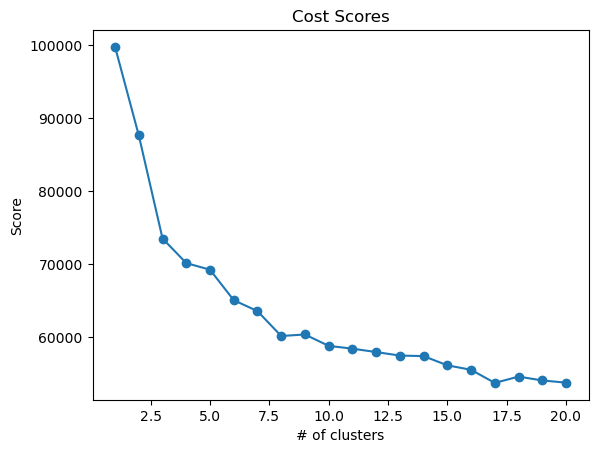

In [69]:
#check cost scores to find optimal number of clusters
cost_list = []

for k in range(1,21):
    kmodes = KModes(n_clusters=k, random_state = 42, n_jobs=-1)
    kmodes.fit(X_cat)
    cost_list.append(kmodes.cost_)

plt.plot(range(1,21), cost_list, marker = 'o')
plt.xlabel("# of clusters")
plt.ylabel("Score")
plt.title("Cost Scores");

Optimal clusters appears to be 8.

In [70]:
#Fit clustering algorithm with 8 clusters
kmodes = KModes(n_clusters=8, random_state = 42, n_jobs=-1)
kmodes.fit(X_cat)
X_kmodes = X_cat.copy()
X_kmodes['cluster'] = kmodes.labels_

### KModes Analysis

In [71]:
#frequency of observations in each cluster
X_kmodes['cluster'].value_counts(normalize=True)

0    0.313599
1    0.145407
2    0.127646
5    0.126480
7    0.108271
3    0.076785
6    0.058127
4    0.043685
Name: cluster, dtype: float64

In [72]:
#amount of observations in each cluster
X_kmodes['cluster'].value_counts().to_frame('count')

,count
0,3496
1,1621
2,1423
5,1410
7,1207
3,856
6,648
4,487


There is much more balance in the clusters of the categorical features than the clusters of the numberical features.

In [73]:
#find modes of each feature by cluster
X_kmodes.groupby("cluster").agg(lambda x: x.value_counts().index[0])

,FAM_RELATIONSHIP,OCCUPATION,EDU_LVL,MARITAL,SEX,MILITARY,HISPANIC,IMMIGR_YR,CITIZENSHIP,DISABLED,RACE,WORK_INDUSTRY,LABOR_STATUS,WRK_STATUS,NO_WRK_RSN,FT_PT,EARN_SOURCE,ERN_OTR,WORK_DIS,TAX_FILE_STAT,HEALTH_INS,PUB_INS,PRIV_INS,POV_STS
cluster,,,,,,,,,,,,,,,,,,,,,,,,
0,not fam,none,high school graduate,married/civilian spouse,female,no,no,not immigrant,native,no,White only,Not applicable,retired,Not in labor force,retired,nonworker,unemployed,under 15,no,single,yes,covered all year,no coverage,in poverty
1,not fam,Service,high school graduate,single,male,no,no,not immigrant,native,no,White only,"Educational services, and health care and soci...",employed/at work,FT hours,not applicable,ft all year,wage,no,no,single,yes,no coverage,covered all year,in poverty
2,child,none,children,single,male,ineligible,no,not immigrant,native,not included,White only,Not applicable,not applicable,Child,not applicable,under 15,unemployed,under 15,under 15,nonfiler,yes,covered all year,no coverage,in poverty
3,ref person,none,high school graduate,married/civilian spouse,female,no,yes,2010s,non citizen,no,White only,Not applicable,not in labor force/other,Not in labor force,taking care of home,nonworker,unemployed,under 15,no,joint under 65 y/o,yes,no coverage,no coverage,in poverty
4,not fam,none,high school graduate,single,male,no,no,not immigrant,native,no,White only,Not applicable,not in labor force/other,Not in labor force,not applicable,ft part year,wage,no,no,single,no,no coverage,no coverage,in poverty
5,child,none,high school no diploma,single,male,no,no,not immigrant,native,no,White only,Not applicable,not in labor force/other,Not in labor force,going to school,nonworker,unemployed,under 15,no,nonfiler,yes,no coverage,no coverage,in poverty
6,ref person,Service,high school graduate,single,female,no,yes,2000s,non citizen,no,White only,"Arts, entertainment, recreation and accomodati...",employed/at work,FT hours,not applicable,ft all year,wage,no,no,single,yes,no coverage,no coverage,in poverty
7,not fam,none,high school graduate,single,male,no,no,not immigrant,native,yes,White only,Not applicable,disabled,Not in labor force,ill or disabled,nonworker,unemployed,under 15,yes,single,yes,covered all year,no coverage,in poverty


Clusters are split on a number of features such as employment status, citizenship, disability, family relationship type, and type of insurance coverage.
* White civilians with no income source outside main job (if applicable) are most common person-type in all clusters.<br>
* Excluding Cluster 4, possessing health insurance is most common. Exluding Cluster 2, high school graduate is most common educational level. Excluding Clusters 1 and 6, no occupation is most common occupation type. Lastly, excluding Clusters 0 and 3, single is the most common marital status.<br>
* Based on the modes of these clusters, the profile of the most common imporverished individual in this dataset would be a white, native male that is unemployed and possesses both a high school level education and health insurance. 
* Clusters 1 and 6 seem to have the most financially stable individuals. People in these clusters are mainly employed in the Service Industry and are single. Cluster 1 is dominated by native men with private insurance whereas 6 is dominated by non-citizen women with varied types of insurance. <br>
* Clusters 2 and 5 feature mainly children. <br>
* Clusters 3 and 6 contain many immigrants. <br>
* Cluster 7 is distinguished by featuring a number of people whose disability limits their ability to work whereas Cluster 0 is distinguished by being composed of many retired females that are not considered family.  

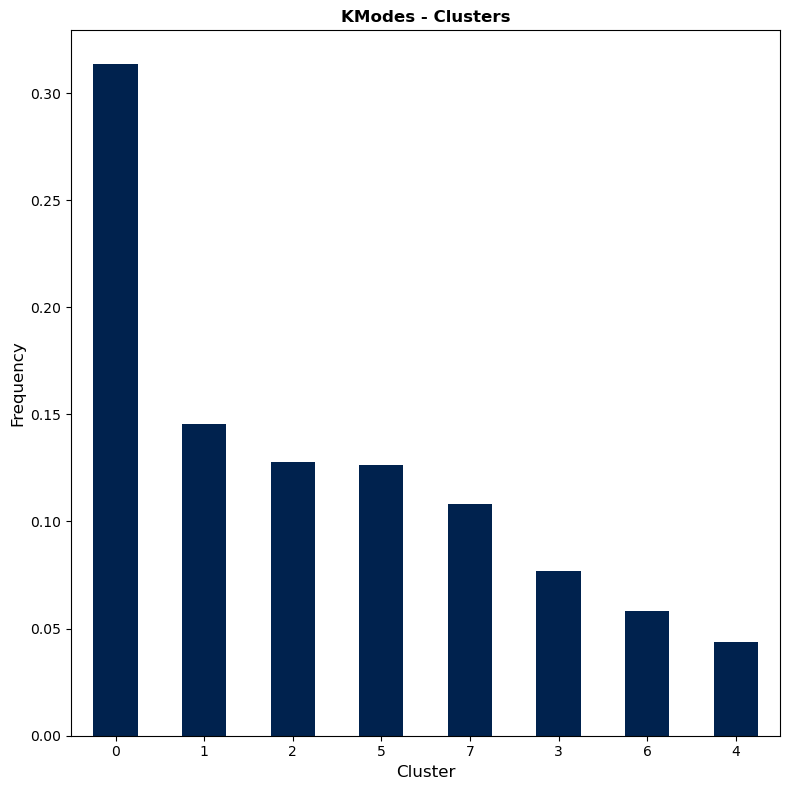

In [128]:
#graphically represent percentage of people per cluster
cluster_plot(X_kmodes, 'cluster', 'KModes')

The balance of amounts of people included in each cluster and the diversity exhibited amongst the clusters present a number of interesting analytical opportunities. Family relationship, age, and health insurance are all previously examined in the classification models. For this next analysis, individuals with disablitiles will be further researched. 

### Disability Analysis

In [109]:
print(df["DISABLED"].value_counts())
print("==============================")
print(df["DISABLED"].value_counts(normalize = True))

no              7586
yes             2130
not included    1432
Name: DISABLED, dtype: int64
no              0.680481
yes             0.191066
not included    0.128454
Name: DISABLED, dtype: float64


2130 (19%) of people with poverty in this dataset have a debilitating disability. 

In [133]:
df[df["DISABLED"] == 'yes']['LABOR_STATUS'].value_counts(normalize = True)

retired                     0.424883
disabled                    0.359624
not in labor force/other    0.110329
employed/at work            0.071831
unemployed/looking          0.022066
employed/absent             0.009390
unemployed                  0.001878
Name: LABOR_STATUS, dtype: float64

About 8% of people in poverty with disabilities that affect ability to work are employed.

In [88]:
df[df["DISABLED"] == 'yes']['DIS_INC'].value_counts(normalize = True)

did not receive                             0.984507
 other or don't know                        0.004695
state or local gov't employee disability    0.003756
company or union disability                 0.002817
accident or disability insurance            0.001878
worker's compensation                       0.000939
federal government disability               0.000939
US military retirement disability           0.000469
Name: DIS_INC, dtype: float64

Over 98% of people in poverty with disabilities that affect ability to work didn't receive disability income. 

In [96]:
df[df["DISABLED"] == 'yes']['FAM_RELATIONSHIP'].value_counts(normalize = True)

not fam            0.509390
ref person         0.246479
spouse             0.116901
child              0.065728
other relatives    0.061502
Name: FAM_RELATIONSHIP, dtype: float64

About half of these individuals live in locations in which they are not considered family.

In [112]:
print(df[df["DISABLED"] == 'yes']["HEALTH_INS"].value_counts(normalize = True))
print("==============================")
print(df[df["DISABLED"] == 'yes']["PUB_INS"].value_counts(normalize = True))
print("==============================")
print(df[df["DISABLED"] == 'yes']["PRIV_INS"].value_counts(normalize = True))

yes    0.906573
no     0.093427
Name: HEALTH_INS, dtype: float64
covered all year    0.784507
no coverage         0.196244
some coverage       0.019249
Name: PUB_INS, dtype: float64
no coverage         0.748826
covered all year    0.233803
some coverage       0.017371
Name: PRIV_INS, dtype: float64


Majority have year-round public insurance coverage. 

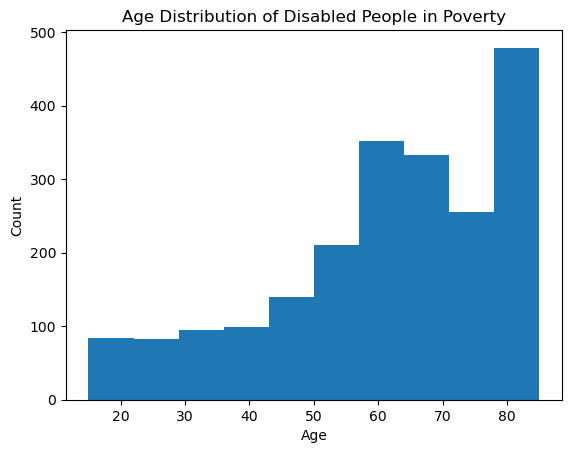

In [115]:
df[df["DISABLED"] == 'yes']['AGE'].plot(kind = "hist")
plt.title("Age Distribution of Disabled People in Poverty")
plt.ylabel("Count")
plt.xlabel("Age");

Distribution is left-skewed with many of these individuals having an advanced age. 

## Mixed Clustering
---

### KPrototypes

In [77]:
#find position of categorical variables for KPrototypes
cat_pos = [X_transformed.columns.get_loc(col) for col in list(X_transformed.select_dtypes('object').columns)]

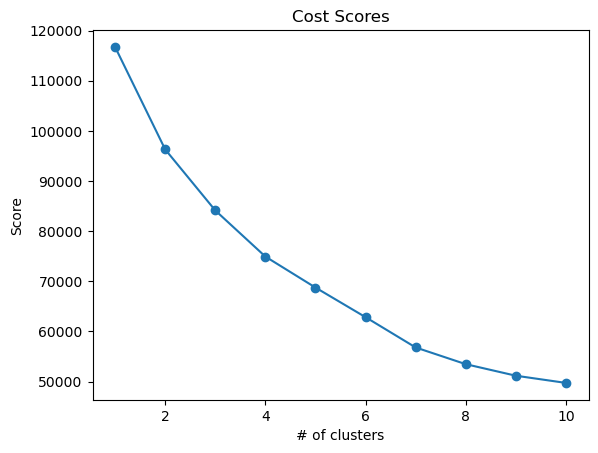

In [201]:
#check cost scores to find optimal number of clusters
cost_list = []

for k in range(1,11):
    kproto = KPrototypes(n_clusters=k, random_state = 42,n_jobs=-1)
    kproto.fit(X_transformed,categorical = cat_pos)
    cost_list.append(kproto.cost_)

plt.plot(range(1,11), cost_list, marker = 'o')
plt.xlabel("# of clusters")
plt.ylabel("Score")
plt.title("Cost Scores");

Optimal clusters appears to be 7.

In [79]:
#Fit clustering algorithm with 7 clusters
kproto = KPrototypes(n_clusters=7, random_state = 42,n_jobs=-1)
kproto.fit(X_transformed,categorical = cat_pos)
X_kproto = X.copy()
X_kproto['cluster'] = kproto.labels_

### KPrototypes Analysis

In [117]:
#frequency of observations in each cluster
X_kproto['cluster'].value_counts(normalize=True)

0    0.373520
6    0.297452
1    0.181826
2    0.129978
3    0.013186
5    0.002691
4    0.001346
Name: cluster, dtype: float64

In [121]:
#amount of observations in each cluster
X_kproto['cluster'].value_counts().to_frame('count')

,count
0,4164
6,3316
1,2027
2,1449
3,147
5,30
4,15


Some clusters have minimal amounts of data. There is less balance compared to the cluster distribution of KModes.

In [130]:
#present list of columns for processing
X_transformed.columns

Index(['WEEKS_WRK', 'AGE', 'EARN_TOTAL', 'ADJ_GROSS_INC', 'OUT_POCKET_NONPREM',
       'OUT_POCKET_OC', 'FAM_RELATIONSHIP', 'OCCUPATION', 'EDU_LVL', 'MARITAL',
       'SEX', 'MILITARY', 'HISPANIC', 'IMMIGR_YR', 'CITIZENSHIP', 'DISABLED',
       'RACE', 'WORK_INDUSTRY', 'LABOR_STATUS', 'WRK_STATUS', 'NO_WRK_RSN',
       'FT_PT', 'EARN_SOURCE', 'ERN_OTR', 'WORK_DIS', 'TAX_FILE_STAT',
       'HEALTH_INS', 'PUB_INS', 'PRIV_INS', 'POV_STS'],
      dtype='object')

In [132]:
#grouping source:
'''
https://towardsdatascience.com/the-k-prototype-as-clustering-algorithm-for-mixed-data-type-categorical
-and-numerical-fe7c50538ebb
'''
X_kproto.groupby('cluster').agg(
    {
      'WEEKS_WRK' : 'median',
        'AGE' : 'median',
        'EARN_TOTAL' : 'median',
        'ADJ_GROSS_INC' : 'median',
        'OUT_POCKET_NONPREM' : 'median',
       'OUT_POCKET_OC' : 'median',
        'FAM_RELATIONSHIP' : lambda x: x.value_counts().index[0],
        'OCCUPATION' : lambda x: x.value_counts().index[0],
        'EDU_LVL' : lambda x: x.value_counts().index[0],
        'MARITAL' : lambda x: x.value_counts().index[0],
       'SEX' : lambda x: x.value_counts().index[0],
        'MILITARY' : lambda x: x.value_counts().index[0],
        'HISPANIC' : lambda x: x.value_counts().index[0],
        'IMMIGR_YR' : lambda x: x.value_counts().index[0],
        'CITIZENSHIP' : lambda x: x.value_counts().index[0],
        'DISABLED' : lambda x: x.value_counts().index[0],
       'RACE' : lambda x: x.value_counts().index[0],
        'WORK_INDUSTRY' : lambda x: x.value_counts().index[0],
        'LABOR_STATUS' : lambda x: x.value_counts().index[0],
        'WRK_STATUS' : lambda x: x.value_counts().index[0],
        'NO_WRK_RSN' : lambda x: x.value_counts().index[0],
       'FT_PT' : lambda x: x.value_counts().index[0],
        'EARN_SOURCE' : lambda x: x.value_counts().index[0],
        'ERN_OTR' : lambda x: x.value_counts().index[0],
        'WORK_DIS' : lambda x: x.value_counts().index[0],
        'TAX_FILE_STAT' : lambda x: x.value_counts().index[0],
       'HEALTH_INS' : lambda x: x.value_counts().index[0],
        'PUB_INS' : lambda x: x.value_counts().index[0],
        'PRIV_INS' : lambda x: x.value_counts().index[0],
        'POV_STS' : lambda x: x.value_counts().index[0]  
    }
)

,WEEKS_WRK,AGE,EARN_TOTAL,ADJ_GROSS_INC,OUT_POCKET_NONPREM,OUT_POCKET_OC,FAM_RELATIONSHIP,OCCUPATION,EDU_LVL,MARITAL,SEX,MILITARY,HISPANIC,IMMIGR_YR,CITIZENSHIP,DISABLED,RACE,WORK_INDUSTRY,LABOR_STATUS,WRK_STATUS,NO_WRK_RSN,FT_PT,EARN_SOURCE,ERN_OTR,WORK_DIS,TAX_FILE_STAT,HEALTH_INS,PUB_INS,PRIV_INS,POV_STS
cluster,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
0,0.0,67.0,0.0,0.0,60.0,60.0,not fam,none,high school graduate,married/civilian spouse,female,no,no,not immigrant,native,no,White only,Not applicable,retired,Not in labor force,retired,nonworker,unemployed,under 15,no,single,yes,covered all year,no coverage,in poverty
1,52.0,41.0,10500.0,10702.0,25.0,50.0,not fam,Service,high school graduate,single,male,no,no,not immigrant,native,no,White only,"Educational services, and health care and soci...",employed/at work,FT hours,not applicable,ft all year,wage,no,no,single,yes,no coverage,no coverage,in poverty
2,0.0,7.0,0.0,0.0,0.0,6.0,child,none,children,single,male,ineligible,no,not immigrant,native,not included,White only,Not applicable,not applicable,Child,not applicable,under 15,unemployed,under 15,under 15,nonfiler,yes,covered all year,no coverage,in poverty
3,0.0,62.0,0.0,1.0,2000.0,2000.0,not fam,none,high school graduate,married/civilian spouse,female,no,no,not immigrant,native,no,White only,Not applicable,retired,Not in labor force,retired,nonworker,unemployed,under 15,no,single,yes,covered all year,no coverage,in poverty
4,36.0,46.0,12000.0,15604.0,80000.0,200.0,ref person,none,high school graduate,married/civilian spouse,male,no,no,not immigrant,native,no,White only,Not applicable,employed/at work,FT hours,not applicable,ft all year,wage,no,no,joint under 65 y/o,yes,no coverage,covered all year,in poverty
5,38.0,63.5,1825.0,780622.5,500.0,160.0,ref person,none,bachelor's degree,married/civilian spouse,male,no,no,not immigrant,native,no,White only,Not applicable,employed/at work,Not in labor force,not applicable,nonworker,wage,no,no,joint under 65 y/o,yes,no coverage,covered all year,in poverty
6,0.0,28.0,0.0,0.0,0.0,25.0,not fam,none,high school graduate,single,female,no,no,not immigrant,native,no,White only,Not applicable,not in labor force/other,Not in labor force,going to school,nonworker,unemployed,under 15,no,single,yes,no coverage,no coverage,in poverty


Clusters are split on a number of features such as employment status, sex, family relationship type, marital status, age, earnings, and type of insurance coverage.
* White, native civilians with insurance and no income source outside main job (if applicable) are most common person-type in all clusters.<br>
* Relative to the clusters from KModes:
> * There is a greater appearance of married individuals and individuals with health insurance (specifically private insurance). Additionally, higher education (bachelor's degree) is a mode in one of the clusters.
> * There is less presence of Hispanic individuals and immigrants.
> * There is no easily seen appearance of disabled individuals.
> * There is a very similar proportion of Family Relationship values.
> * Service occupation type is notably present using both models.
* Clusters 0 and 3 match on nearly every median and mode value. The main difference appears to be the out of pocket amount spent on health services.<br>
* Clusters 4 and 5  feature very few individuals. This may be due to extreme income and earnings values.<br>
* Clusters 2 features many children. Cluster 6 also appears to feature many young people.<br>

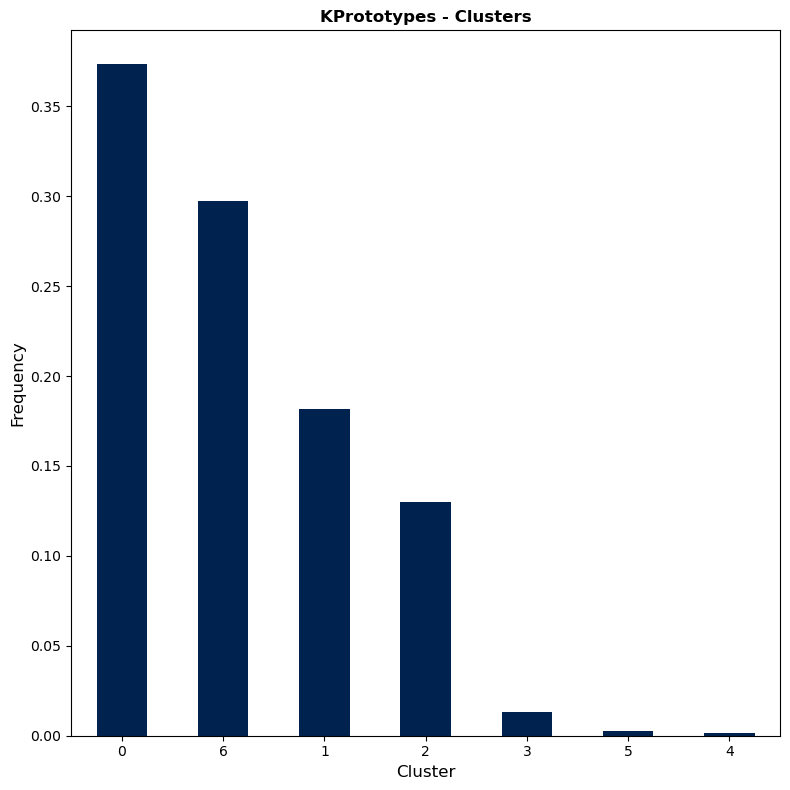

In [127]:
#graphically represent percentage of people per cluster
cluster_plot(X_kproto, 'cluster', 'KPrototypes')

Percentage of impoverished people per cluster.

## Clustering Conclusion

In this analysis, KMeans, KModes and KPrototypes highlighted different features of the minority classes in the dataset such as disability status, citizenship, medical expenses, and education levels. KMeans helped showcase some differences between various age groups. KModes clustering aided in the examination of the conditions of disabled individuals in poverty. KPrototypes, for example, could spur an additional study on qualities of impoverished people with esteemed educational backgrounds. In general, the number and type of features used in a clustering algorithm affect the optimal number of clusters and the main characteristics of the data in those clusters. Additionally, the type of clustering model can greatly shape how the data is ultimately arranged. It's apparent in both the analysis of KMeans and KPrototypes clustering that extreme income and earning values created smaller, less useful clusters. Domain expertise seems to be paramount in order to properly group data for the most fruitful analysis.